<a href="https://colab.research.google.com/github/julianrosen/erdos_dl_recanvo_project/blob/main/sj/P01%20AST%20%3A%20Classifying%20ReCanVo%20Audio%20Data%20with%20AST%20and%20Logistic%20Regression%20for%20Participant%2001.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifying Audio Data using AST and Logistic Regression for Participant 1

## Premise of the Project

Our work is building upon the results from a 2021 paper titled “Transfer Learning with Real-World Nonverbal Vocalizations from Minimally Speaking Individuals” [https://www.media.mit.edu/publications/transfer-learning-with-real-world-nonverbal-vocalizations-from-minimally-speaking-individuals/] We use the ReCanVo dataset that the original authors had gathered. Each audio clip is labled by caretakers with tags such as "Happy", Dysregulated" , "Hungry" , etc.

<br>

## In this part of the project:
We check how feasible it is to use AST as a way of extraxting features from the audio data, in order to build a classifier that  predicts the label.


<br>


AST [Audio Spectrogram Transformer] is a purely attention based model developed by Yuan Gong, Yu-An Chung, and James Glass for audio classification. [References: https://arxiv.org/pdf/2104.01778, https://github.com/YuanGongND/ast/tree/master] We use the first five layers of their model to extract features.

<br>

## This Notebook


Here, We consider participant # 01 and we drop labels that have fewer than 30 data points. Features have been already extracted from AST in a previous notebook. The Goal of this notebook is to check how feasible it is to use AST features in order to build a classifier that  predicts the label.






In [1]:
# Update/install packages to make google colab happy.

! pip install -U scikit-learn
! pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 15.7 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successfully uninstalled scikit-learn-1.3.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 630.2 kB/s eta 0:00:00


In [2]:
# Imports

import functools
from pathlib import Path

import torchaudio.transforms as T
import math


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    confusion_matrix,
    f1_score,
    log_loss,
    recall_score,
)
from sklearn.model_selection import (
    cross_val_predict,
    StratifiedKFold,
)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
#self note: removed the skopt line below so it'll work, if it gives errors
from skopt import BayesSearchCV
import torch
import torchaudio
from tqdm.notebook import tqdm


def to_prob(metric):
    @functools.wraps(metric)
    def metric_that_takes_prob(y_actual, y_pred, sample_weight=None):
        return metric(y_actual, y_pred.argmax(1), sample_weight=sample_weight)

    return metric_that_takes_prob


metrics = {
    "accuracy": to_prob(accuracy_score),
    "balanced_accuracy": to_prob(balanced_accuracy_score),
    "unweighted_f1": to_prob(functools.partial(f1_score, average="macro")),
    "UAR": to_prob(functools.partial(recall_score, average="macro")),
    "logloss": log_loss,
}

## Section 1 : Import the AST Features

In [3]:
#import the feature tensors

from google.colab import files
uploaded = files.upload()


Saving X_testP1_2.pt to X_testP1_2.pt
Saving X_testP1_3.pt to X_testP1_3.pt
Saving X_testP1_4.pt to X_testP1_4.pt
Saving y_testP1.pt to y_testP1.pt
Saving X_testP1_1.pt to X_testP1_1.pt
Saving X_trainP1_2.pt to X_trainP1_2.pt
Saving X_trainP1_3.pt to X_trainP1_3.pt
Saving X_trainP1_4.pt to X_trainP1_4.pt
Saving y_trainP1.pt to y_trainP1.pt
Saving X_trainP1_1.pt to X_trainP1_1.pt


In [4]:
# make feature tensors

import torch

X_1 = torch.load('X_trainP1_1.pt')
X_2 = torch.load('X_trainP1_2.pt')
X_3 = torch.load('X_trainP1_3.pt')
X_4 = torch.load('X_trainP1_4.pt')
y = torch.load('y_trainP1.pt')
# Check shapes
print(X_1.shape , X_2.shape, X_3.shape, X_4.shape, y.shape)


torch.Size([1287, 128]) torch.Size([1287, 1212]) torch.Size([1287, 1212]) torch.Size([1287, 1212]) torch.Size([1287])


<ipython-input-4-31e416550124>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  X_1 = torch.load('X_trainP1_1.pt')
<ipython-input-4-31e416550124>:6: FutureWarning: You are u

In [7]:
X_1_test = torch.load('X_trainP1_1.pt')
X_2_test = torch.load('X_trainP1_2.pt')
X_3_test = torch.load('X_trainP1_3.pt')
X_4_test = torch.load('X_trainP1_4.pt')
y_test = torch.load('y_trainP1.pt')


# Check shapes
print(X_1_test.shape , y_test.shape)

torch.Size([1287, 128]) torch.Size([1287])


<ipython-input-7-78849ee7e5a3>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  X_1_test = torch.load('X_trainP1_1.pt')
<ipython-input-7-78849ee7e5a3>:2: FutureWarning: You 

## Section 2 : Some Preliminary Things for the Logistic Regression Set-Up

In [8]:
# data files [importing the train test split made by Ale from the link: https://drive.google.com/uc?id=1zMQzBcjoMXR1FipmrFXJ0rjD7S5IgeT4]
! gdown 1zMQzBcjoMXR1FipmrFXJ0rjD7S5IgeT4 -O /content/new_train_test.csv

Downloading...
From: https://drive.google.com/uc?id=1zMQzBcjoMXR1FipmrFXJ0rjD7S5IgeT4
To: /content/new_train_test.csv
100% 523k/523k [00:00<00:00, 114MB/s]


In [9]:
#create a dataframe to hold the data
df = pd.read_csv('/content/new_train_test.csv')
#check labels
display(df.Label.value_counts())


,count
Label,
selftalk,1885
frustrated,1536
delighted,1272
dysregulated,704
social,634
request,419
affectionate,129
yes,123
laughter,93


In [10]:
# Dropping lower label counts in the entire dataset
## this cell maybe redundant since we do this specifically for P01 later
Label_counts = df.Label.value_counts()
Label_enough = Label_counts[Label_counts >= 30]

df_dropped = df.loc[df.Label.isin(Label_enough.index)]

display(df_dropped.Label.value_counts())

,count
Label,
selftalk,1885
frustrated,1536
delighted,1272
dysregulated,704
social,634
request,419
affectionate,129
yes,123
laughter,93


In [11]:
#Isolate the data for participant #01
df_P01 = df.loc[df.Participant == "P01"]

#check labels
display(df_P01.Label.value_counts())

,count
Label,
selftalk,564
delighted,357
dysregulated,212
social,182
frustrated,150
request,130
dysregulation-sick,74
bathroom,20
dysregulation-bathroom,18


In [12]:
# drop labels with count less than 30 [DOUBLE CHECK]
# P01
Label_counts1 = df_P01.Label.value_counts()
Label_enough1 = Label_counts1[Label_counts1 >= 30]

df_P01_dropped = df_P01.loc[df_P01.Label.isin(Label_enough1.index)]

display(df_P01_dropped.Label.value_counts())

,count
Label,
selftalk,564
delighted,357
dysregulated,212
social,182
frustrated,150
request,130
dysregulation-sick,74


In [13]:
#Make the label list for later

Labels = []

# Use a for loop to populate the list
for i in Label_enough1.index:
    Labels.append(i)

print(Labels)

['selftalk', 'delighted', 'dysregulated', 'social', 'frustrated', 'request', 'dysregulation-sick']


In [14]:
#create dataframes that contain training and testing data seperately for participant 0q
#we may not need the testing data frame in this notebook since we've already extracted the features

train_P01 = df_P01_dropped.loc[df_P01_dropped.is_test == 0]
test_P01 = df_P01_dropped.loc[df_P01_dropped.is_test == 1]

In [15]:
# Some possible sample weights for training and/or metrics.
# session_weight weights each sample based on sessions, so
# that the total weight of observations in each sesion is
# constant. On top of that, session_and_label_weight assigns
# a label to each weight, which is multiplied by the sesion weight,
# in such a way to make the sum of the weights constant by label.
session_weight = (
    (1 / train_P01.Session.value_counts())
    .clip(None, 0.1)
    .loc[train_P01.Session]
).values
session_and_label_weight = (
    1
    / pd.Series(session_weight, train_P01.index)
    .groupby(train_P01.Label)
    .sum()
).loc[train_P01.Label].values * session_weight

## Section 3: Logistic Regression for Feature X_1

X_1 = output of the initial AST layer (which was a 2dim tensor of size 1024 x 128 whose entries were averaged over the dimension with the longer length, which gives us 128 features for each datapoint.)


In [16]:
# checking accuracy for feature set 1 : X_1
est = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        max_iter=10**6,
    ),
)
opt = BayesSearchCV(
    est,
    {
        "logisticregression__C": (5e-3, 1, "log-uniform"),
    },
    n_iter=20,
    cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=12345),
    scoring="accuracy",
)
opt.fit(
    X_1.reshape(len(X_1), -1),
    y,
)
print(opt.best_params_)
print("Best accuracy:", opt.best_score_)

OrderedDict([('logisticregression__C', 0.6113406905181563)])
Best accuracy: 0.7047238372093023


In [17]:
#save the best param
P_1 = opt.best_params_

In [18]:
print(P_1)

OrderedDict([('logisticregression__C', 0.6113406905181563)])


In [19]:
# Generate out-of-sample predictions using a logistic
# regression model, with the parameter determined by
# the optimization above.
#
# We compute various metrics, using various weightings
est = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        C=opt.best_params_["logisticregression__C"],
        max_iter=10**6,
    ),
)
oos_pred_prob = cross_val_predict(
    est,
    X_1.reshape(len(X_1), -1),
    y,
    cv=StratifiedKFold(
        n_splits=10,
        shuffle=True,
        random_state=1234,  # Using different seed to avoid over-fitting parameter
    ),
    method="predict_proba",
    #params={"logisticregression__sample_weight": session_weight}, ##just checking
)
oos_pred = oos_pred_prob.argmax(1)

display(
    pd.Series(
        {name: metric(y, oos_pred_prob) for name, metric in metrics.items()},
        name="no_weight",
    ).round(3)
)
display(
    pd.Series(
        {
            name: metric(y, oos_pred_prob, sample_weight=session_weight)
            for name, metric in metrics.items()
        },
        name="session_weight",
    ).round(3)
)
display(
    pd.Series(
        {
            name: metric(
                y, oos_pred_prob, sample_weight=session_and_label_weight
            )
            for name, metric in metrics.items()
        },
        name="session_and_label_weight",
    ).round(3)
)

,no_weight
accuracy,0.695
balanced_accuracy,0.691
unweighted_f1,0.698
UAR,0.691
logloss,0.851


,session_weight
accuracy,0.626
balanced_accuracy,0.674
unweighted_f1,0.671
UAR,0.674
logloss,0.998


,session_and_label_weight
accuracy,0.674
balanced_accuracy,0.674
unweighted_f1,0.690
UAR,0.674
logloss,0.959


In [20]:
# Confusion matrix

conf_matrix_df = pd.DataFrame(
    confusion_matrix(y, oos_pred), columns=Labels, index=Labels
)
conf_matrix_df.index.name = "actual_label"
conf_matrix_df.columns.name = "pred_label"
display(conf_matrix_df)

pred_label,selftalk,delighted,dysregulated,social,frustrated,request,dysregulation-sick
actual_label,,,,,,,
selftalk,42,4,1,1,8,0,3
delighted,0,59,0,0,26,2,12
dysregulated,0,1,155,2,8,1,5
social,1,2,1,101,21,4,13
frustrated,11,18,8,19,322,14,46
request,0,1,0,3,18,68,16
dysregulation-sick,5,7,8,15,80,8,147


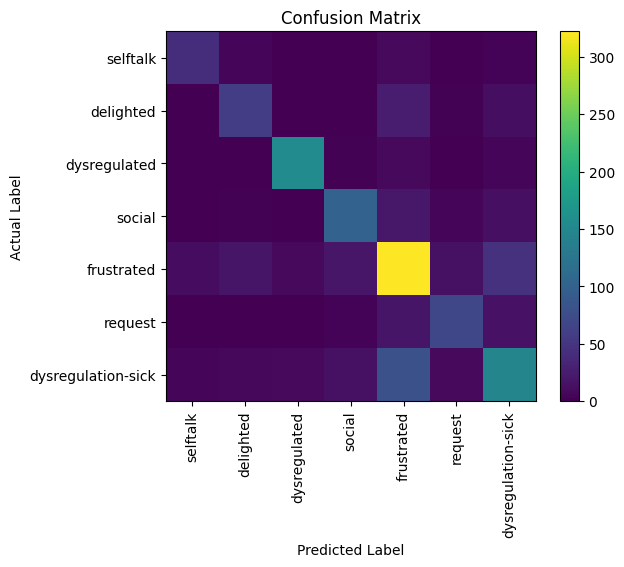

In [21]:
# Create a heatmap
plt.imshow(conf_matrix_df, cmap='viridis', interpolation='nearest')

# Add a colorbar to show the scale
plt.colorbar()

# Add labels and title if desired
plt.xticks(range(len(Labels)), labels=Labels, rotation='vertical')
plt.yticks(range(len(Labels)), labels=Labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')

# Show the plot
plt.show()

## Section 4: Logistic Regression for Feature X_2

X_2 = output of the 1st attention layer of AST

In [22]:
# checking accuracy for feature set 1 : X_2
est = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        max_iter=10**6,
    ),
)
opt = BayesSearchCV(
    est,
    {
        "logisticregression__C": (5e-3, 1, "log-uniform"),
    },
    n_iter=20,
    cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=12345),
    scoring="accuracy",
)
opt.fit(
    X_2.reshape(len(X_2), -1),
    y,
)
print(opt.best_params_)
print("Best accuracy:", opt.best_score_)

OrderedDict([('logisticregression__C', 0.006381537011925901)])
Best accuracy: 0.5003997093023256


In [23]:
#save the best param
P_2 = opt.best_params_

In [24]:
# Generate out-of-sample predictions using a logistic
# regression model, with the parameter determined by
# the optimization above.
#
# We compute various metrics, using various weightings
est = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        C=opt.best_params_["logisticregression__C"],
        max_iter=10**6,
    ),
)
oos_pred_prob = cross_val_predict(
    est,
    X_2.reshape(len(X_2), -1),
    y,
    cv=StratifiedKFold(
        n_splits=10,
        shuffle=True,
        random_state=1234,  # Using different seed to avoid over-fitting parameter
    ),
    method="predict_proba",
    #params={"logisticregression__sample_weight": session_weight}, ##just checking
)
oos_pred = oos_pred_prob.argmax(1)

display(
    pd.Series(
        {name: metric(y, oos_pred_prob) for name, metric in metrics.items()},
        name="no_weight",
    ).round(3)
)
display(
    pd.Series(
        {
            name: metric(y, oos_pred_prob, sample_weight=session_weight)
            for name, metric in metrics.items()
        },
        name="session_weight",
    ).round(3)
)
display(
    pd.Series(
        {
            name: metric(
                y, oos_pred_prob, sample_weight=session_and_label_weight
            )
            for name, metric in metrics.items()
        },
        name="session_and_label_weight",
    ).round(3)
)

,no_weight
accuracy,0.508
balanced_accuracy,0.454
unweighted_f1,0.481
UAR,0.454
logloss,1.276


,session_weight
accuracy,0.443
balanced_accuracy,0.442
unweighted_f1,0.457
UAR,0.442
logloss,1.412


,session_and_label_weight
accuracy,0.442
balanced_accuracy,0.442
unweighted_f1,0.467
UAR,0.442
logloss,1.464


In [25]:
# Confusion matrix

conf_matrix_df = pd.DataFrame(
    confusion_matrix(y, oos_pred), columns=Labels, index=Labels
)
conf_matrix_df.index.name = "actual_label"
conf_matrix_df.columns.name = "pred_label"
display(conf_matrix_df)

pred_label,selftalk,delighted,dysregulated,social,frustrated,request,dysregulation-sick
actual_label,,,,,,,
selftalk,21,5,2,1,26,1,3
delighted,0,30,4,2,42,3,18
dysregulated,0,1,119,0,34,2,16
social,0,1,0,66,47,1,28
frustrated,10,10,30,30,269,20,69
request,0,0,0,3,58,35,10
dysregulation-sick,2,14,18,26,85,11,114


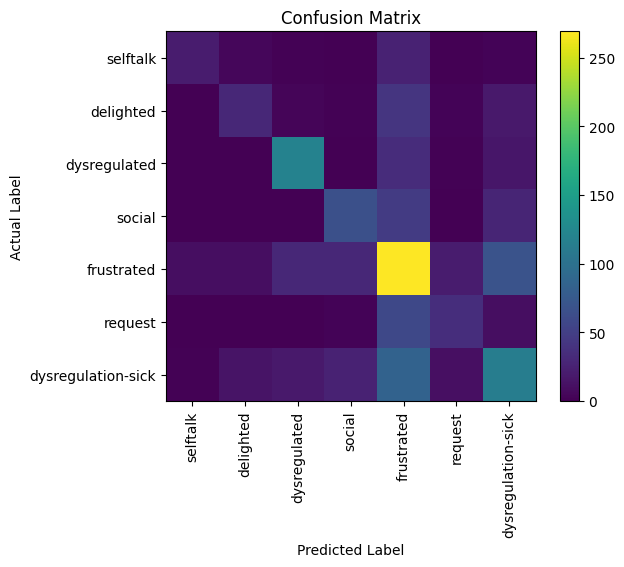

In [26]:
# Create a heatmap
plt.imshow(conf_matrix_df, cmap='viridis', interpolation='nearest')

# Add a colorbar to show the scale
plt.colorbar()

# Add labels and title if desired
plt.xticks(range(len(Labels)), labels=Labels, rotation='vertical')
plt.yticks(range(len(Labels)), labels=Labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')

# Show the plot
plt.show()

## Section 5: Logistic Regression for Feature X_3

X_3 = output of the 5th attention layer of AST

In [27]:
# checking accuracy for feature set 1 : X_3
est = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        max_iter=10**6,
    ),
)
opt = BayesSearchCV(
    est,
    {
        "logisticregression__C": (5e-3, 1, "log-uniform"),
    },
    n_iter=20,
    cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=12345),
    scoring="accuracy",
)
opt.fit(
    X_3.reshape(len(X_3), -1),
    y,
)
print(opt.best_params_)
print("Best accuracy:", opt.best_score_)

OrderedDict([('logisticregression__C', 0.005)])
Best accuracy: 0.39169694767441865


In [28]:
#save the best param
P_3 = opt.best_params_

In [29]:
# Generate out-of-sample predictions using a logistic
# regression model, with the parameter determined by
# the optimization above.
#
# We compute various metrics, using various weightings
est = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        C=opt.best_params_["logisticregression__C"],
        max_iter=10**6,
    ),
)
oos_pred_prob = cross_val_predict(
    est,
    X_3.reshape(len(X_3), -1),
    y,
    cv=StratifiedKFold(
        n_splits=10,
        shuffle=True,
        random_state=1234,  # Using different seed to avoid over-fitting parameter
    ),
    method="predict_proba",
    #params={"logisticregression__sample_weight": session_weight}, ##just checking
)
oos_pred = oos_pred_prob.argmax(1)

display(
    pd.Series(
        {name: metric(y, oos_pred_prob) for name, metric in metrics.items()},
        name="no_weight",
    ).round(3)
)
display(
    pd.Series(
        {
            name: metric(y, oos_pred_prob, sample_weight=session_weight)
            for name, metric in metrics.items()
        },
        name="session_weight",
    ).round(3)
)
display(
    pd.Series(
        {
            name: metric(
                y, oos_pred_prob, sample_weight=session_and_label_weight
            )
            for name, metric in metrics.items()
        },
        name="session_and_label_weight",
    ).round(3)
)

,no_weight
accuracy,0.399
balanced_accuracy,0.293
unweighted_f1,0.301
UAR,0.293
logloss,1.581


,session_weight
accuracy,0.345
balanced_accuracy,0.295
unweighted_f1,0.290
UAR,0.295
logloss,1.697


,session_and_label_weight
accuracy,0.295
balanced_accuracy,0.295
unweighted_f1,0.276
UAR,0.295
logloss,1.837


In [30]:
# Confusion matrix

conf_matrix_df = pd.DataFrame(
    confusion_matrix(y, oos_pred), columns=Labels, index=Labels
)
conf_matrix_df.index.name = "actual_label"
conf_matrix_df.columns.name = "pred_label"
display(conf_matrix_df)

pred_label,selftalk,delighted,dysregulated,social,frustrated,request,dysregulation-sick
actual_label,,,,,,,
selftalk,7,0,4,5,29,0,14
delighted,0,6,8,9,56,5,15
dysregulated,0,4,104,4,45,3,12
social,1,2,5,35,62,1,37
frustrated,3,8,41,32,260,15,79
request,1,3,6,4,58,10,24
dysregulation-sick,1,4,14,25,131,4,91


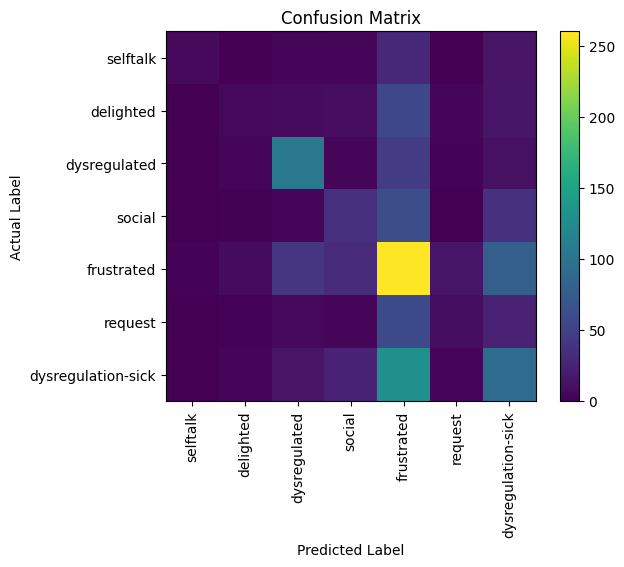

In [31]:
# Create a heatmap
plt.imshow(conf_matrix_df, cmap='viridis', interpolation='nearest')

# Add a colorbar to show the scale
plt.colorbar()

# Add labels and title if desired
plt.xticks(range(len(Labels)), labels=Labels, rotation='vertical')
plt.yticks(range(len(Labels)), labels=Labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')

# Show the plot
plt.show()

## Section 6: Logistic Regression for Feature X_4

X_4 = output of the 3rd attention layer of AST

In [32]:
# checking accuracy for feature set 1 : X_4
est = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        max_iter=10**6,
    ),
)
opt = BayesSearchCV(
    est,
    {
        "logisticregression__C": (5e-3, 1, "log-uniform"),
    },
    n_iter=20,
    cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=12345),
    scoring="accuracy",
)
opt.fit(
    X_4.reshape(len(X_4), -1),
    y,
)
print(opt.best_params_)
print("Best accuracy:", opt.best_score_)

OrderedDict([('logisticregression__C', 0.005)])
Best accuracy: 0.4078730620155039


In [33]:
#save the best param
P_4 = opt.best_params_

In [34]:
# Generate out-of-sample predictions using a logistic
# regression model, with the parameter determined by
# the optimization above.
#
# We compute various metrics, using various weightings
est = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        C=opt.best_params_["logisticregression__C"],
        max_iter=10**6,
    ),
)
oos_pred_prob = cross_val_predict(
    est,
    X_4.reshape(len(X_4), -1),
    y,
    cv=StratifiedKFold(
        n_splits=10,
        shuffle=True,
        random_state=1234,  # Using different seed to avoid over-fitting parameter
    ),
    method="predict_proba",
    #params={"logisticregression__sample_weight": session_weight}, ##just checking
)
oos_pred = oos_pred_prob.argmax(1)

display(
    pd.Series(
        {name: metric(y, oos_pred_prob) for name, metric in metrics.items()},
        name="no_weight",
    ).round(3)
)
display(
    pd.Series(
        {
            name: metric(y, oos_pred_prob, sample_weight=session_weight)
            for name, metric in metrics.items()
        },
        name="session_weight",
    ).round(3)
)
display(
    pd.Series(
        {
            name: metric(
                y, oos_pred_prob, sample_weight=session_and_label_weight
            )
            for name, metric in metrics.items()
        },
        name="session_and_label_weight",
    ).round(3)
)

,no_weight
accuracy,0.423
balanced_accuracy,0.344
unweighted_f1,0.371
UAR,0.344
logloss,1.461


,session_weight
accuracy,0.358
balanced_accuracy,0.338
unweighted_f1,0.351
UAR,0.338
logloss,1.580


,session_and_label_weight
accuracy,0.338
balanced_accuracy,0.338
unweighted_f1,0.350
UAR,0.338
logloss,1.687


In [35]:
# Confusion matrix

conf_matrix_df = pd.DataFrame(
    confusion_matrix(y, oos_pred), columns=Labels, index=Labels
)
conf_matrix_df.index.name = "actual_label"
conf_matrix_df.columns.name = "pred_label"
display(conf_matrix_df)

pred_label,selftalk,delighted,dysregulated,social,frustrated,request,dysregulation-sick
actual_label,,,,,,,
selftalk,16,0,4,0,20,0,19
delighted,0,8,4,2,66,4,15
dysregulated,0,3,104,2,39,1,23
social,1,2,2,42,56,0,40
frustrated,4,14,25,27,256,14,98
request,1,0,1,3,60,24,17
dysregulation-sick,3,4,21,16,123,9,94


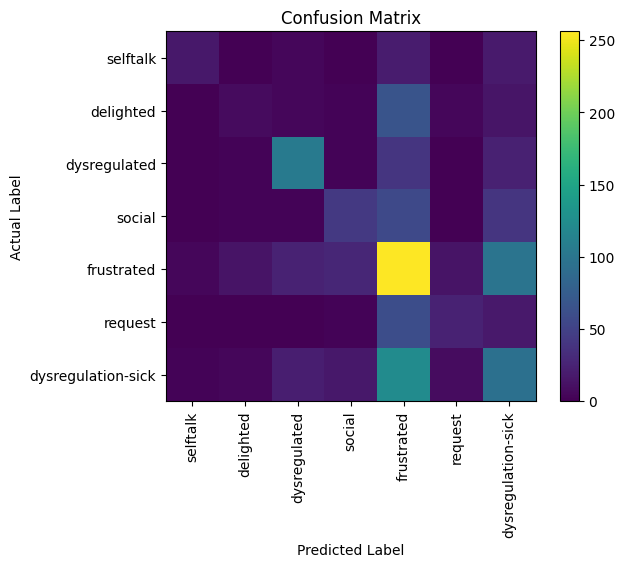

In [36]:
# Create a heatmap
plt.imshow(conf_matrix_df, cmap='viridis', interpolation='nearest')

# Add a colorbar to show the scale
plt.colorbar()

# Add labels and title if desired
plt.xticks(range(len(Labels)), labels=Labels, rotation='vertical')
plt.yticks(range(len(Labels)), labels=Labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')

# Show the plot
plt.show()

## Section 7 : Predictions Based on the Best Performing Feature

In [37]:
#Pick the best performing feature

X_test = X_1_test


In [38]:
#Optimal parameter for the best feature [EDIT CELL]
P = P_1

In [39]:
print(P)

OrderedDict([('logisticregression__C', 0.6113406905181563)])


In [47]:
X_train = X_1
y_train = y

print(X_train.shape , y_train.shape)

torch.Size([1287, 128]) torch.Size([1287])


In [42]:
#the model
model = LogisticRegression(C=0.6113406905181563)
model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=0.6113406905181563)

In [43]:
# Predict the probabilities for the test set
probabilities = model.predict_proba(X_test)

# Predict the class labels for the test set
predictions = model.predict(X_test) ## Should X_test should be replaced with X_test.reshape(len(X_test), -1) ?

#metrics

#checking accuracy
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy}')

# Compute the balanced accuracy score
balanced_accuracy = balanced_accuracy_score(y_test, predictions)
print(f'Balanced Accuracy Score: {balanced_accuracy}')

#f1 score
f1 = f1_score(y_test, predictions, average='macro')
print(f'F1 Score: {f1}')

Accuracy: 0.6985236985236986
Balanced Accuracy Score: 0.6446981946854702
F1 Score: 0.6821675926839437


In [44]:
# Confusion matrix

conf_matrix_df = pd.DataFrame(
    confusion_matrix(y_test, predictions), columns=Labels, index=Labels
)
conf_matrix_df.index.name = "actual_label"
conf_matrix_df.columns.name = "pred_label"
display(conf_matrix_df)

pred_label,selftalk,delighted,dysregulated,social,frustrated,request,dysregulation-sick
actual_label,,,,,,,
selftalk,29,3,2,1,22,0,2
delighted,1,51,0,0,34,1,12
dysregulated,0,0,155,2,12,0,3
social,1,1,0,104,27,2,8
frustrated,5,13,7,22,356,3,32
request,0,0,1,3,32,54,16
dysregulation-sick,0,6,8,10,92,4,150


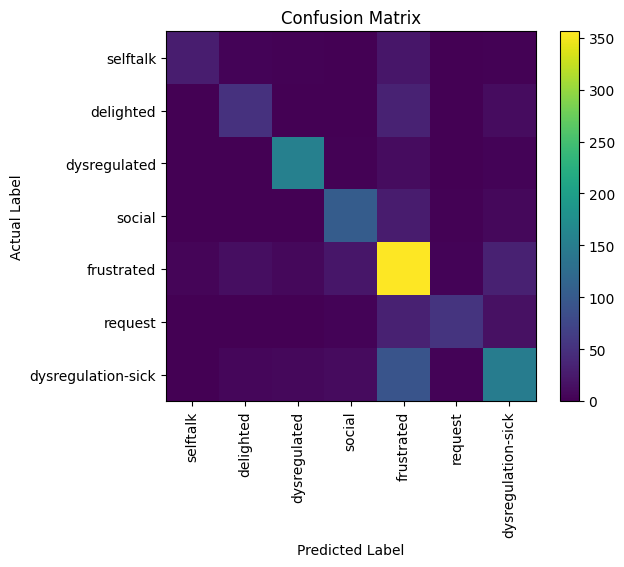

In [46]:
# Create a heatmap
plt.imshow(conf_matrix_df, cmap='viridis', interpolation='nearest')

# Add a colorbar to show the scale
plt.colorbar()

# Add labels and title if desired
plt.xticks(range(len(Labels)), labels=Labels, rotation='vertical')
plt.yticks(range(len(Labels)), labels=Labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')

# Show the plot
plt.show()